In [2]:
import matplotlib.pyplot as plt
import numpy as np

recorded_opinions = np.load("recorded_opinions.npy", allow_pickle=True).item()

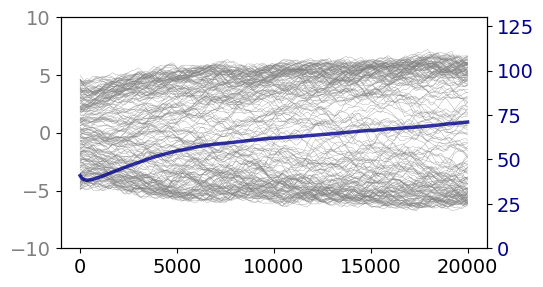

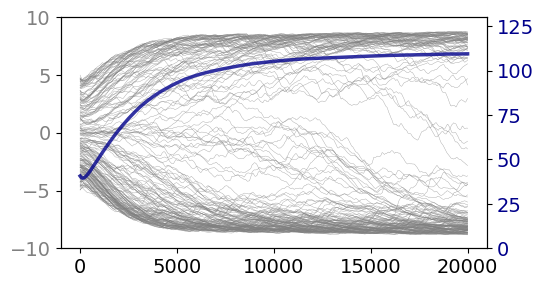

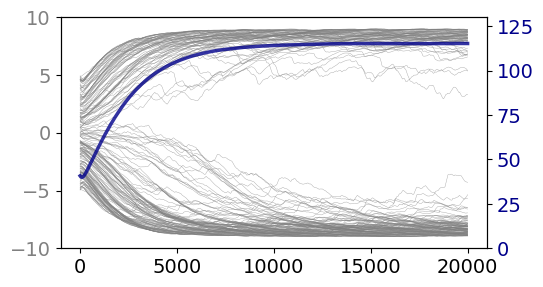

In [3]:
def average_pol(opinions_array):
    # Calculate polarization for each time step across all simulations
    polarization_per_step = [
        np.mean([np.linalg.norm(opinions) for opinions in opinions_array[:, step, :]])
        for step in range(opinions_array.shape[1])
    ]
    return np.array(polarization_per_step)

alphas = [0.2]
betas = [1]
gammas = [0.3, 0.6, 0.9]

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            # Get the opinion trajectory for one of the simulations (e.g., index 1)
            try:
                recorded_opinions_array = np.array(recorded_opinions[(alpha, beta, gamma)][1])  # shape: (n_times, n_nodes)
            except KeyError:
                print(f"No data for combination: alpha={alpha}, beta={beta}, gamma={gamma}")
                continue
            fig, ax1 = plt.subplots(figsize=(5.5, 3))
            time_steps = np.arange(0, len(recorded_opinions_array))
            n_nodes = recorded_opinions_array.shape[1]

            for node in range(n_nodes):
                ax1.plot(time_steps, recorded_opinions_array[:, node], alpha=0.7, color="gray", linewidth=0.3)
            ax1.set_ylim(-10, 10)
            ax1.set_yticks((-10,-5, 0, 5, 10))
            ax1.set_xticks((0,5000, 10000,15000, 20000))
            ax1.tick_params(axis='y', labelcolor='gray', labelsize=14)
            ax1.tick_params(axis='x', labelcolor='black', labelsize=14)
            
            ax2 = ax1.twinx()
            ax2.plot(np.arange(0, recorded_opinions[(alpha, beta, gamma)].shape[1]), average_pol(recorded_opinions[(alpha, beta, gamma)]), alpha=0.8, linewidth=2.5, color='darkblue')
            ax2.set_ylim(0, 130)
            ax2.set_yticks((0, 25, 50, 75, 100, 125))
            ax2.tick_params(axis='y', labelcolor='darkblue', labelsize=14)


In [ ]:
import random
import numpy as np

def minmax_policy(state, env):
    if state["tau"] is None:
        return np.argmax(state["sigma"])
    else:
        sigma_values = np.array(state["sigma"])
        return np.argmin(sigma_values[np.setdiff1d(np.arange(len(sigma_values)), state["graph"].neighbors(state["tau"]))])

def minmax_policy_soft(state, env):
    def activation(source, target, opinion_range):
        return np.tanh(0.2*(1 - abs(source - target) / (opinion_range))*source)
    
    if state["tau"] is None:
        sigma_values = np.array(state["sigma"])
        if random.random() < 0.5:
            threshold_top  = np.percentile(sigma_values, 75)
            candidates = np.where(sigma_values >= threshold_top)[0]
            return random.choice(candidates) 
        else:
            threshold_bottom  = np.percentile(sigma_values, 25)
            candidates = np.where(sigma_values <= threshold_bottom)[0]
            return random.choice(candidates) 
    else:
        sigma_values = np.array(state["sigma"])
        target = state["tau"]
        target_opinion = sigma_values[target]
        opinion_range = np.max(sigma_values) - np.min(sigma_values)
        non_neighbors = np.setdiff1d(np.arange(len(sigma_values)), list(state["graph"].neighbors(target)))
        return min(non_neighbors, key=lambda node: np.sign(target_opinion) * activation(sigma_values[node], target_opinion, opinion_range))
    
def deleting_policy(state, env):
    if state["tau"] is None:
        if random.random() < 0.5:
            return np.argmax(state["sigma"])  
        else:
            return np.argmin(state["sigma"])
    else:
        sigma_values = np.array(state["sigma"])
        neighbors = list(state["graph"].neighbors(state["tau"]))
        if not neighbors:
            return 0  # No neighbors available
        return min(neighbors, key=lambda node: abs(sigma_values[node] - sigma_values[state["tau"]]))
    
def greedy_policy(state, env):
    if state["tau"] is None:
        sigma_values = np.array(state["sigma"])
        if random.random() < 0.5:
            threshold_top  = np.percentile(sigma_values, 75)
            candidates = np.where(sigma_values >= threshold_top)[0]
            return random.choice(candidates) 
        else:
            threshold_bottom  = np.percentile(sigma_values, 25)
            candidates = np.where(sigma_values <= threshold_bottom)[0]
            return random.choice(candidates) 
    else:
        tau = state["tau"]
        best_node = None
        best_value = float('inf')
        for i in range(200):
            G_new = state["graph"].copy()
            if G_new.has_edge(tau, i):
                G_new.remove_edge(tau, i)
            else:
                G_new.add_edge(tau, i)
            sigma_new = env.opinion_updates(G_new, state["sigma"])
            if env.polarization(sigma_new) < best_value:
                best_value = env.polarization(sigma_new)
                best_node = i
        return best_node

In [16]:
sigma_values = np.array(state["sigma"])
threshold_top  = np.percentile(sigma_values, 75)
candidates = np.where(sigma_values >= threshold_top)[0]
# return max(candidates, key=lambda node: state["sigma"][node])

In [ ]:
candidates
random_candidate = random.choice(candidates)
print(random_candidate)

array([  1,  10,  14,  18,  29,  32,  37,  38,  40,  42,  46,  50,  54,
        57,  58,  64,  68,  72,  73,  74,  77,  80,  81,  84,  86,  87,
        88,  92,  94,  99, 100, 104, 113, 114, 123, 134, 135, 136, 141,
       146, 154, 161, 163, 167, 168, 172, 175, 188, 195, 197])

In [28]:
from evaluation import *
from visualization import *
from env import NLOpinionDynamics

env = NLOpinionDynamics(n = 200, alpha=0.2, beta=1, gamma = 0.6, average_degree=6, n_edge_updates_per_step = 5)

state = env.reset()
recorded_graphs = [(state['graph'], state['sigma'])]
opinions = [state['sigma'].copy()]  # Initialize with the initial opinions
for time_step in range(1, 20001):
    action = deleting_policy(state)
    next_state, _, _ = env.step(action)
    if time_step % 2 == 0:
        opinions.append(next_state['sigma'].copy())
    if time_step % 10000 == 0:
        recorded_graphs.append((next_state['graph'], next_state['sigma']))
    state = next_state

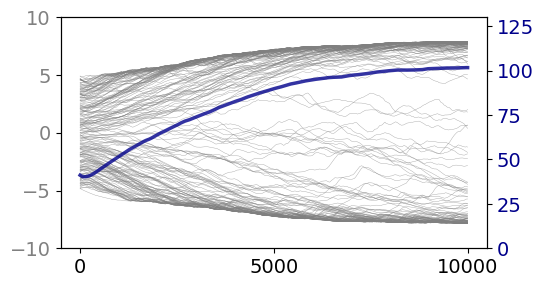

In [29]:
def average_pol(opinions_array):
    # Calculate polarization for each time step across all simulations
    polarization_per_step = [
        np.mean([np.linalg.norm(opinions) for opinions in opinions_array[:, step, :]])
        for step in range(opinions_array.shape[1])
    ]
    return np.array(polarization_per_step)

# Get the opinion trajectory for one of the simulations (e.g., index 1)
recorded_opinions_array = np.array(opinions)  # shape: (n_times, n_nodes)

fig, ax1 = plt.subplots(figsize=(5.5, 3))
time_steps = np.arange(0, len(recorded_opinions_array))
n_nodes = recorded_opinions_array.shape[1]

for node in range(n_nodes):
    ax1.plot(time_steps, recorded_opinions_array[:, node], alpha=0.7, color="gray", linewidth=0.3)
ax1.set_ylim(-10, 10)
ax1.set_yticks((-10,-5, 0, 5, 10))
ax1.set_xticks((0,5000, 10000,15000, 20000))
ax1.tick_params(axis='y', labelcolor='gray', labelsize=14)
ax1.tick_params(axis='x', labelcolor='black', labelsize=14)

recorded_opinions_array = np.array([opinions])  # shape: (n_times, n_nodes)
ax2 = ax1.twinx()
ax2.plot(np.arange(0, recorded_opinions_array.shape[1]), average_pol(recorded_opinions_array), alpha=0.8, linewidth=2.5, color='darkblue')
ax2.set_ylim(0, 130)
ax2.set_yticks((0, 25, 50, 75, 100, 125))
ax2.tick_params(axis='y', labelcolor='darkblue', labelsize=14)


In [2]:
import pickle

with open("opinions/GraphSage-complex-n150-k0-hd128-layers4-lr0.0001-heads0-bs64-p1-g0.8-tuf500-QEKK1_opinions.pkl", "rb") as f:
    opinions_data = pickle.load(f)

In [3]:
opinions_data.shape

torch.Size([1, 20000, 150])

In [7]:
# from evaluation import *
from visualization import *

run_name = "Graphormer-complex-n175-k15-hd128-layers2-lr0.0004-heads4-bs64-tuf100000-Q1W5G"
visualize_comparison_dqn_vs_greedy_simple(run_name)
# compare_dqn_policy_to_greedy_single_setting(run_name, n=75, k=20)
# visualize_comparison_dqn_vs_greedy_single_setting(run_name)

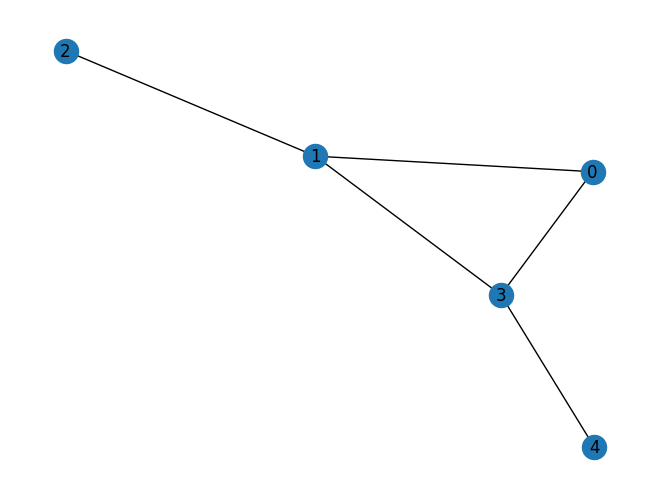

In [ ]:
import networkx as nx
from scipy.sparse.csgraph import shortest_path



G = nx.erdos_renyi_graph(n=5, p=0.5)
nx.draw(G, with_labels=True)
plt.show()


In [26]:
spd = shortest_path(nx.to_numpy_array(G), directed=False, unweighted=True)
- spd + (np.max(spd))

array([[3., 2., 1., 2., 1.],
       [2., 3., 2., 2., 1.],
       [1., 2., 3., 1., 0.],
       [2., 2., 1., 3., 2.],
       [1., 1., 0., 2., 3.]])

In [13]:
L = nx.laplacian_matrix(G).toarray()
I = np.eye(L.shape[0])
influence_matrix = np.linalg.inv(I + L)
influence_matrix

array([[0.44444444, 0.16666667, 0.11111111, 0.16666667, 0.11111111],
       [0.16666667, 0.33333333, 0.16666667, 0.16666667, 0.16666667],
       [0.11111111, 0.16666667, 0.37777778, 0.16666667, 0.17777778],
       [0.16666667, 0.16666667, 0.16666667, 0.33333333, 0.16666667],
       [0.11111111, 0.16666667, 0.17777778, 0.16666667, 0.37777778]])